In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [20]:
#HYPERPARAMETERS
data_dir = '/Users/nlonberg/Desktop/train' #FILEPATH
img_resize_dims = [224,224]
# Batch sizes are typically base2
train_batch_size = 8
test_batch_size = 8 # Number of samples between parameter adjustments
test_size = 0.2
epochs = 5 # Epochs = Number of times to fully loop back over training data to tune hyperparameters

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [22]:
#MODEL SELECTION: PRETRAINED RESNET50
model_name = "ResNet50"
model = models.resnet50(pretrained=True)
#model = models.vgg16(pretrained=True)

In [23]:
def load_split_train_test(datadir, valid_size = .2):
    
    # Build pytorch image transformation pipelines
    # Bootstrapping transformers could go HERE
    train_transforms = transforms.Compose([transforms.Resize(img_resize_dims),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(img_resize_dims),
                                      transforms.ToTensor(),
                                      ])
    
    # Load in images
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    #Build Train-Test Data Loaders
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=train_batch_size)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=test_batch_size)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, test_size)
print(trainloader.dataset.classes)

['1', '10', '2', '3', '4', '5', '6', '7', '8', '9']


In [24]:
# Freeze pretrained model's layers
for param in model.parameters():
    param.requires_grad = False

# Redefine final layer(s) for training
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(), # "ReLu Is Great" -Kelly, Used for internal layer for many NNs
                                 # Rectified linear unit function
                                 nn.Dropout(0.2),
                                 # Dropout Layer: Randomly zero some neurons with p=20% to prevent overfitting
                                 nn.Linear(512, 10), # Activation Function Used for Output for Regression
                                 # Linear Transformation Layer
                                 nn.LogSoftmax(dim=1)) # Good for Multi-class classifications
                                 # Log Softmax function for penalizing incorrect classifications
# Define Loss Function
criterion = nn.NLLLoss()
# Root-Mean-Squared Propagation is also a optimizer that is used
# Define Gradient Descent Optimizer
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device);

In [25]:
steps = 0
running_loss = 0
# Print every 5 batches
print_every = 5
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
            
torch.save(model, model_name+'.pth')

Epoch 1/5.. Train loss: 4.892.. Test loss: 4.315.. Test accuracy: 0.263
Epoch 1/5.. Train loss: 2.755.. Test loss: 2.018.. Test accuracy: 0.285
Epoch 1/5.. Train loss: 1.768.. Test loss: 2.195.. Test accuracy: 0.350
Epoch 1/5.. Train loss: 2.103.. Test loss: 2.074.. Test accuracy: 0.226
Epoch 1/5.. Train loss: 1.943.. Test loss: 1.843.. Test accuracy: 0.266
Epoch 1/5.. Train loss: 1.768.. Test loss: 1.571.. Test accuracy: 0.299
Epoch 1/5.. Train loss: 1.609.. Test loss: 1.548.. Test accuracy: 0.373
Epoch 1/5.. Train loss: 1.695.. Test loss: 1.573.. Test accuracy: 0.248
Epoch 1/5.. Train loss: 1.712.. Test loss: 1.480.. Test accuracy: 0.383
Epoch 1/5.. Train loss: 1.557.. Test loss: 1.480.. Test accuracy: 0.293
Epoch 1/5.. Train loss: 1.394.. Test loss: 1.529.. Test accuracy: 0.308
Epoch 1/5.. Train loss: 1.630.. Test loss: 1.631.. Test accuracy: 0.279
Epoch 1/5.. Train loss: 1.381.. Test loss: 1.616.. Test accuracy: 0.223
Epoch 1/5.. Train loss: 1.636.. Test loss: 1.379.. Test accuracy

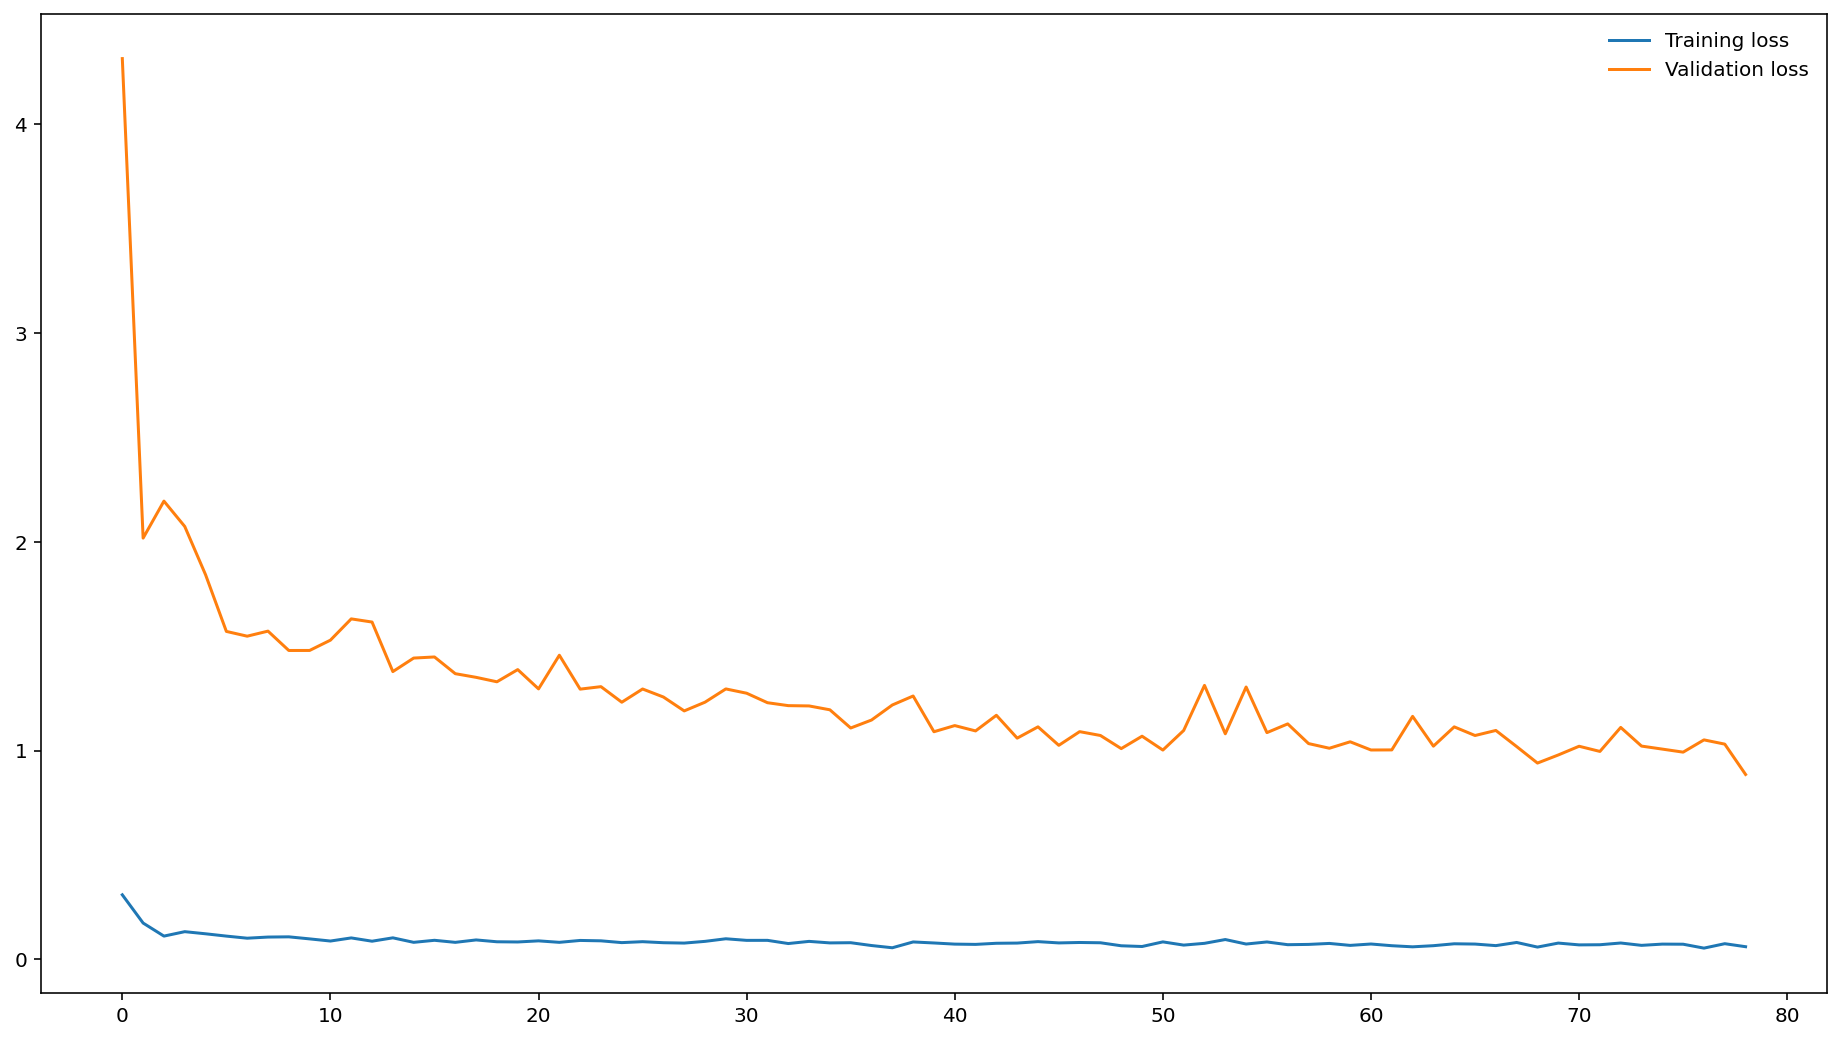

In [26]:
plt.figure(figsize=(16,9))
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()